In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path

import numpy as np
import re
import music21 as m21
import glob
import pandas as pd

score_path_glob = "../musicxml/*.xml"

INTERVAL_LABELS = {
    "NC": "NC",
    "P8": "R",
    "P1": "R",
    "d1": "7",
    "d8": "7",
    "A8": "b9",
    "A1": "b9",
    "m2": "b9",
    "M2": "9",
    "d2": "X",
    "A2": "b3",
    "d3": "9",
    "m3": "b3",
    "M3": "3",
    "A3": "11",
    "d4": "3",
    "P4": "11",
    "A4": "b5",
    "AA4": "5",
    "dd5": "11",
    "d5": "b5",
    "d6": "5",
    "P5": "5",
    "A5": "b13",
    "m6": "b13",
    "M6": "13",
    "A6": "b7",
    "d7": "13",
    "m7": "b7",
    "M7": "7",
    "A7": "R",
    "m9": "b9",
    "d9": "b9",
    "M9": "9",
    "P9": "9",
    "A9": "b3",
    "d10": "b3",
    "m10": "b3",
    "M10": "3",
    "A10": "11",
    "d11": "3",
    "P11": "11",
    "A11": "b5",
    "m12": "b5",
    "d12": "b5",
    "M12": "5",
    "P12": "5",
    "A12": "b13",
    "d13": "b13",
    "M13": "13",
    "m13": "b13",
    "A13": "b7",
    "P14": "7",
    "M14": "7",
    "A14": "R",
    "m14": "b7",
    "d14": "b7",
    "A15": "R",
    "m15": "7",
    "d15": "7",
    "P15": "R",
}

TITLES = [
    "All-the-Things-You-Are",
    "Alone-Together",
    "Apple-Jump",
    "Autumn-Leaves",
    "Blues-By-Five",
    "Bye-Bye-Blackbird",
    "C-Jam-Blues",
    "Come-Rain-or-Come-Shine",
    "Cottontail",
    "Dear-Old-Stockholm",
    "Dolphin-dance",
    "Doxy",
    "For-Regulars-Only",
    "Four",
    "Fried-Bananas",
    "Gone-with-the-wind",
    "Have-You-Met-Miss-Jones",
    "Honeysuckle-Rose",
    "I-ll-Remember-April",
    "In-a-Mellow-Tone",
    "In-Your-Own-Sweet-Way",
    "Invitation",
    "Isotope",
    "Just-Friends",
    "Ladybird",
    "Milestones",
    "Montmartre",
    "Namely-You",
    "Nows-the-time",
    "Oleo",
    "On-Green-Dolphin-Street",
    "Out-of-the-Night",
    "Parisian-Thoroughfare",
    "Pennies-from-Heaven",
    "Satin-Doll",
    "Scrapple-From-the-Apple",
    "Sonnymoon-for-Two",
    "Soon",
    "Star-Eyes",
    "Stella-By-Starlight",
    "Step-Lightly",
    "Sweet-Georgia-Brown",
    "Take-the-A-Train",
    "Tangerine",
    "The-Rainbow-People",
    "There-will-never-be-another-you",
    "Three-Little-Words",
    "UMMG",
]

PLAYERS = [
    "Ray Drummond",
    "John Goldsby",
    "Rufus Reid",
    "Rufus Reid",
    "Rufus Reid",
    "Steve Gilmore",
    "John Goldsby",
    "Steve Gilmore",
    "Rufus Reid",
    "Rufus Reid",
    "Ron Carter",
    "Rufus Reid",
    "Rufus Reid",
    "Rufus Reid",
    "Rufus Reid",
    "Wayne Dockery",
    "Steve Gilmore",
    "Tyrone Wheeler",
    "Todd Coolman",
    "John Goldsby",
    "Michael Moore",
    "Steve Gilmore",
    "Tyrone Wheeler",
    "Steve Gilmore",
    "Ray Drummond",
    "Rufus Reid",
    "Rufus Reid",
    "Steve Gilmore",
    "Rufus Reid",
    "Steve Gilmore",
    "Steve Gilmore",
    "Tyrone Wheeler",
    "Dennis Irwin",
    "Tyrone Wheeler",
    "Ron Carter",
    "Ron Carter",
    "Rufus Reid",
    "Todd Coolman",
    "Steve Gilmore",
    "Ron Carter",
    "Tyrone Wheeler",
    "Tyrone Wheeler",
    "Ron Carter",
    "Todd Coolman",
    "Rufus Reid",
    "Christian Doky",
    "Steve Gilmore",
    "Lynn Seaton",
]

# zip TITLES and PLAYERS into dictionary
PLAYER_LOOKUP = dict(zip(TITLES, PLAYERS))

## Annotating and displaying a score

The following cell contains some code to analyse chord symbols and annotate notes with their chord degree, relative to the current chord.

As an example of further processing, we also color roots in red when they occur on a chord change. Any chord change where a root is not played, we colour blue.

The proportion of red to blue notes makes it clear that the bassist prefers to play the root on each new chord, which is one of the findings in our paper.

dlopen error : dlopen(libjack.0.dylib, 0x0001): tried: '/Applications/MuseScore 3.app/Contents/MacOS/../Frameworks/libjack.0.dylib' (no such file), '/Applications/MuseScore 3.app/Contents/MacOS/../Frameworks/libjack.0.dylib' (no such file), 'libjack.0.dylib' (no such file), '/usr/local/lib/libjack.0.dylib' (no such file), '/usr/lib/libjack.0.dylib' (no such file), '/Users/xavriley/Dropbox/PhD/Datasets/FiloBass ISMIR Publication/notebooks/libjack.0.dylib' (no such file) 
dlopen error : dlopen(/usr/local/lib/libjack.0.dylib, 0x0001): tried: '/usr/local/lib/libjack.0.dylib' (no such file) 
Creating main window…
ZoomBox::setLogicalZoom(): Formatting logical zoom level as 100% (rounded from 1.000000)
Reading translations…
convert </var/folders/44/p35k7czj02b6zl50d7w1rst80000gn/T/music21/tmp913hg13u.xml>...
	to </var/folders/44/p35k7czj02b6zl50d7w1rst80000gn/T/music21/tmp913hg13u.png>
... success!


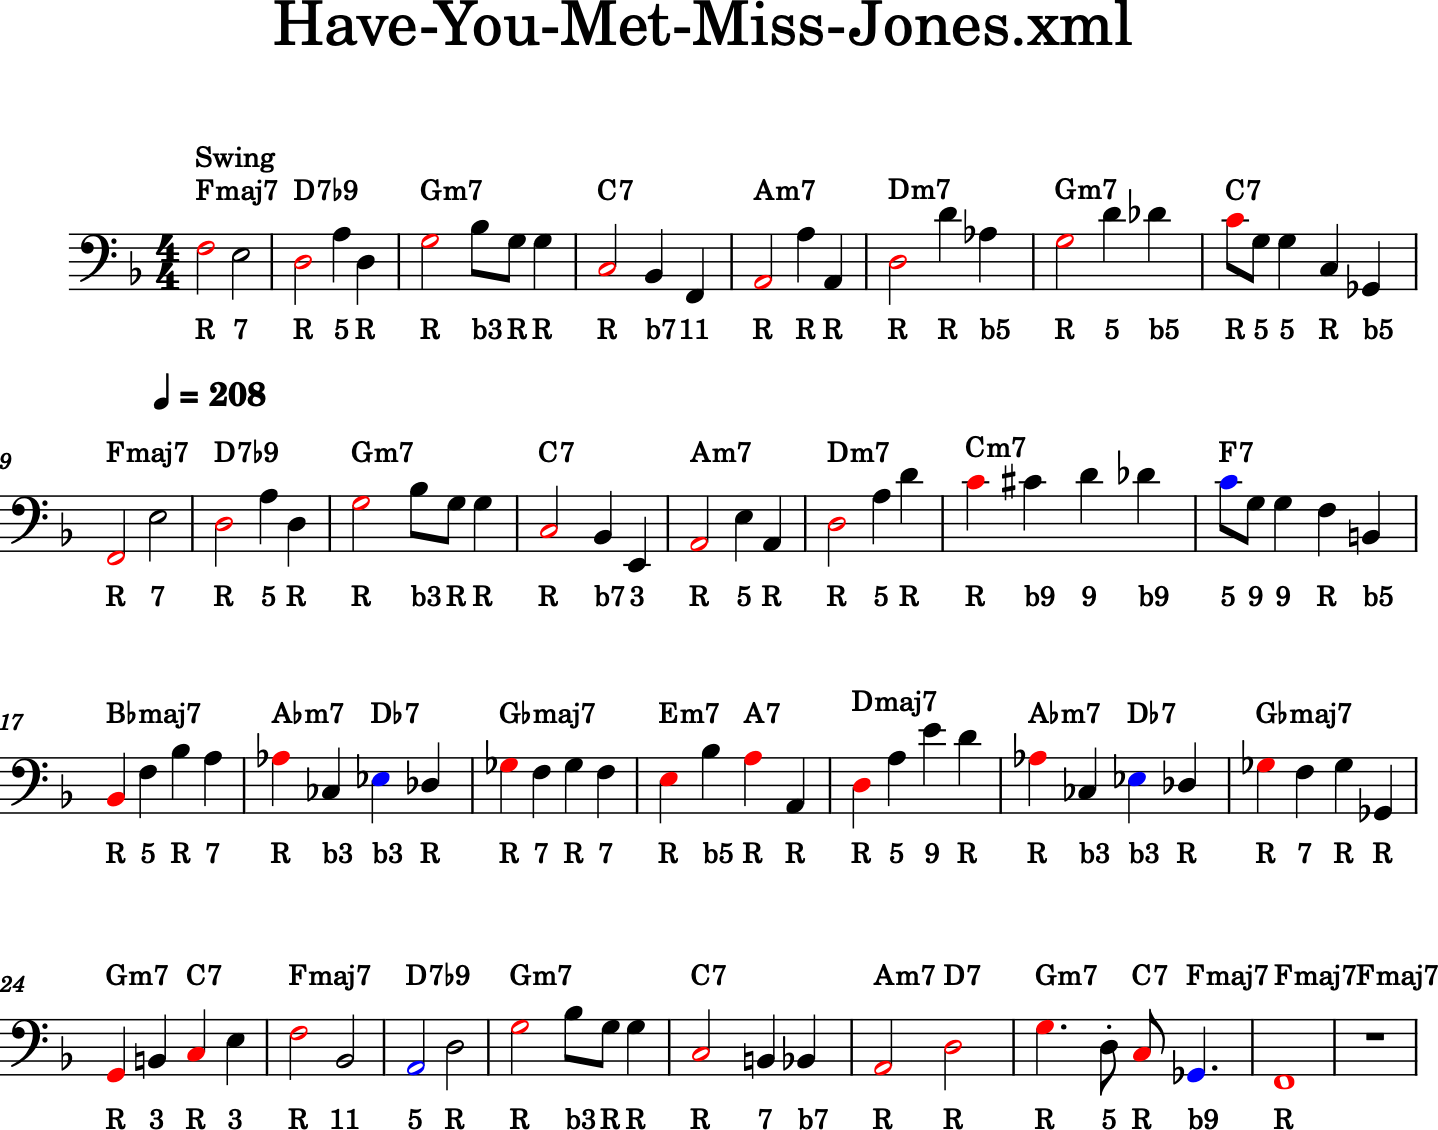

In [108]:
# Example of loading and annotating a score
score_path = Path("../musicxml/Have-You-Met-Miss-Jones.xml")

score = m21.converter.parse(score_path)

# find all bars in score without a chord symbol and add one if missing
# for bar in score.getElementsByClass("Part")[0].getElementsByClass(
#     m21.stream.Measure
# ):
#     if len(bar.getElementsByClass(m21.harmony.ChordSymbol)) == 0:
#         # print(f"Bar {bar.number} has no chord symbol")

#         # insert a chord symbol
#         chord = m21.harmony.ChordSymbol()
#         chord.quarterLength = bar.duration.quarterLength
#         bar.insert(0, chord)

# This would normally be used to force chord symbols to have a duration
# however it causes issues when trying to print a subset of the score using .measures()
# m21.harmony.realizeChordSymbolDurations(score)

notes = score.recurse().notesAndRests.flat

prev_note = None
# get all chords
chords = score.flat.getElementsByClass(m21.harmony.ChordSymbol)

for idx, chord in enumerate(chords):
    # sanitize chord symbol ready for music21 parsing
    kind_str = chord.chordKindStr

    kind_str = kind_str.replace("mmaj", "minmaj")
    kind_str = kind_str.replace("(", "")
    kind_str = kind_str.replace(")", "")

    if "/" in kind_str:
        kind_str, bass_str = kind_str.split("/")
        if bass_str:
            bass_str = bass_str.replace("b", "-")
            bass_str = "/" + bass_str
    else:
        bass_str = ""

    if chord.pitches:
        chord_root = chord.root().name
        chord_root_midi = chord.root().midi
        chord_str = f"{chord_root}{kind_str}"
        if bass_str:
            parsed_chord = m21.harmony.ChordSymbol(chord_str, bass=bass_str[1:])
        else:
            try:
                parsed_chord = m21.harmony.ChordSymbol(chord_str)
            except ValueError as e:
                print(e)
                print(f"Chord: {chord_str}")
                print(f"Bar: {chord.measureNumber}")
                print(f"Score: {score_path}")
                raise
        # print([n.name for n in parsed_chord.notes])
    else:
        chord_root_midi = 0
        chord_root = ""
        chord_str = ""

    if len(chords) > idx + 1:
        next_chord_offset = chords[idx + 1].offset
    else:
        next_chord_offset = -1

    for note in notes.getElementsByOffset(
        chord.offset,
        next_chord_offset,
        includeEndBoundary=False,
        mustBeginInSpan=True,
    ):
        if type(note) not in [m21.note.Note, m21.note.Rest]:
            continue

        if note.isNote:
            if chord_root:
                interval = m21.interval.notesToInterval(
                    m21.pitch.Pitch(chord.root().midi % 12 + 12),
                    m21.pitch.Pitch((note.pitch.midi % 12) + 24),
                )
                note.lyric = INTERVAL_LABELS[interval.name]
                if note.lyric == "R" and note.offset == chord.offset:
                    note.style.color = 'red'
                elif note.offset == chord.offset:
                    note.style.color = 'blue'
            else:
                note.lyric = INTERVAL_LABELS["NC"]

score.measures(1,32).show()

## Generating note data

In our work we generate a large table with information about each note, ready for subsequent analysis. This only needs to be run once to generate the CSV.

## Figures differing from Published paper

Please note: the published paper used the scores before they were proof read by a professional bassist. The corrections from this process may cause totals shown here to differ slightly from the published results as a result. The original uncorrected scores are available on request from the authors. 

In [54]:
def generate_row(
    chord, chord_root, chord_kind, chord_bass, note, degree, prev_note, score_path
):
    if not prev_note:
        direction = 0

    if type(note) is m21.note.Rest or (prev_note and prev_note.isRest):
        direction = 0
        note_pitch = ""
        note_name = "rest"
        interval = -50
    elif note and prev_note and note.pitch.midi == prev_note.pitch.midi:
        direction = 0
        note_pitch = note.pitch.midi
        note_name = note.pitch.name
        interval = 0
    elif note and prev_note and note.pitch.midi > prev_note.pitch.midi:
        direction = 1
        note_pitch = note.pitch.midi
        note_name = note.pitch.name
        interval = note.pitch.midi - prev_note.pitch.midi
    else:
        direction = -1
        note_pitch = note.pitch.midi
        note_name = note.pitch.name
        if prev_note:
            interval = note.pitch.midi - prev_note.pitch.midi
        else:
            interval = -50

    d = {}
    d.update(
        {
            "id": note.id,
            "title": score_path,
            "player": PLAYER_LOOKUP[score_path],
            "type": note.__class__.__name__,
            "note": note_name,
            "note_midi": note_pitch,
            "note_global_offset": note.offset,
            "note_relative_offset": note.offset % 4,
            "note_duration": note.duration.quarterLength,
            "note_degree": degree,
            "note_direction": direction,
            "note_interval": interval,
            "chord": chord_str,
            "chord_root": chord_root,
            "chord_kind": chord_kind,
            "chord_bass": chord_bass,
            # get offset within measure
            "chord_id": chord.id,
            "chord_global_offset": chord.offset,
            "chord_relative_offset": chord.offset % 4,
            "chord_duration": chord.duration.quarterLength,
            "measure_number": note.measureNumber,
        }
    )
    return d


row_list = []
for score_path in sorted(glob.glob(score_path_glob)):
    print(score_path)

    score = m21.converter.parse(score_path)

    # find all bars in score without a chord symbol
    for bar in score.getElementsByClass("Part")[0].getElementsByClass(
        m21.stream.Measure
    ):
        if len(bar.getElementsByClass(m21.harmony.ChordSymbol)) == 0:
            # print(f"Bar {bar.number} has no chord symbol")

            # insert a chord symbol
            chord = m21.harmony.ChordSymbol()
            chord.quarterLength = bar.duration.quarterLength
            bar.insert(0, chord)

    score = m21.harmony.realizeChordSymbolDurations(score)

    notes = score.recurse().notesAndRests.flat

    prev_note = None
    # get all chords
    for chord in score.flat.getElementsByClass(m21.harmony.ChordSymbol):
        kind_str = chord.chordKindStr

        kind_str = kind_str.replace("mmaj", "minmaj")
        kind_str = kind_str.replace("(", "")
        kind_str = kind_str.replace(")", "")

        if "/" in kind_str:
            kind_str, bass_str = kind_str.split("/")
            if bass_str:
                bass_str = bass_str.replace("b", "-")
                bass_str = "/" + bass_str
        else:
            bass_str = ""

        if chord.pitches:
            chord_root = chord.root().name
            chord_root_midi = chord.root().midi
            chord_str = f"{chord_root}{kind_str}"
            if bass_str:
                parsed_chord = m21.harmony.ChordSymbol(chord_str, bass=bass_str[1:])
            else:
                try:
                    parsed_chord = m21.harmony.ChordSymbol(chord_str)
                except ValueError as e:
                    print(e)
                    print(f"Chord: {chord_str}")
                    print(f"Bar: {chord.measureNumber}")
                    print(f"Score: {score_path}")
                    raise
            # print([n.name for n in parsed_chord.notes])
        else:
            chord_root_midi = 0
            chord_root = ""
            chord_str = ""

        for note in notes.getElementsByOffset(
            chord.offset,
            (chord.offset) + (chord.duration.quarterLength),
            includeEndBoundary=False,
            mustBeginInSpan=True,
        ):
            if type(note) not in [m21.note.Note, m21.note.Rest]:
                continue

            if note.isNote:
                if chord_root:
                    interval = m21.interval.notesToInterval(
                        m21.pitch.Pitch(chord.root().midi % 12 + 12),
                        m21.pitch.Pitch((note.pitch.midi % 12) + 24),
                    )
                    note.lyric = INTERVAL_LABELS[interval.name]
                else:
                    note.lyric = INTERVAL_LABELS["NC"]

                row_list.append(
                    generate_row(
                        chord,
                        chord_root,
                        kind_str,
                        bass_str,
                        note,
                        note.lyric,
                        prev_note,
                        Path(score_path).stem,
                    )
                )
            elif note.isRest:
                row_list.append(
                    generate_row(
                        chord,
                        chord_root,
                        kind_str,
                        bass_str,
                        note,
                        "",
                        prev_note,
                        Path(score_path).stem,
                    )
                )
            else:
                # shouldn't happen
                raise

            if note.isNote:
                prev_note = note


pd.DataFrame(row_list).to_csv(f"note_data.csv", index=False)

../musicxml/All-the-Things-You-Are.xml
../musicxml/Alone-Together.xml
../musicxml/Apple-Jump.xml
../musicxml/Autumn-Leaves.xml
../musicxml/Blues-By-Five.xml
../musicxml/Bye-Bye-Blackbird.xml
../musicxml/C-Jam-Blues.xml
../musicxml/Come-Rain-or-Come-Shine.xml
../musicxml/Cottontail.xml
../musicxml/Dear-Old-Stockholm.xml
../musicxml/Dolphin-dance.xml
../musicxml/Doxy.xml
../musicxml/For-Regulars-Only.xml
../musicxml/Four.xml
../musicxml/Fried-Bananas.xml
../musicxml/Gone-with-the-wind.xml
../musicxml/Have-You-Met-Miss-Jones.xml
../musicxml/Honeysuckle-Rose.xml
../musicxml/I-ll-Remember-April.xml
../musicxml/In-Your-Own-Sweet-Way.xml
../musicxml/In-a-Mellow-Tone.xml
../musicxml/Invitation.xml
../musicxml/Isotope.xml
../musicxml/Just-Friends.xml
../musicxml/Ladybird.xml
../musicxml/Milestones.xml
../musicxml/Montmartre.xml
../musicxml/Namely-You.xml
../musicxml/Nows-the-time.xml
../musicxml/Oleo.xml
../musicxml/On-Green-Dolphin-Street.xml
../musicxml/Out-of-the-Night.xml
../musicxml/Parisi

In [30]:
# prepare dataframe
sns.set_theme()

# Read in the data
df = pd.read_csv(
    Path(
        "/Users/xavriley/Dropbox/PhD/Datasets/FiloBass Publication/note_data.csv"
    ).absolute()
)

# resolve issue with data types by converting note_global_offset to float
df["note_global_offset"] = pd.to_numeric(df["note_global_offset"], errors="coerce")
df["note_duration"] = pd.to_numeric(df["note_duration"], errors="coerce")

In [50]:
player_note_counts = df.query('type == "Note"').groupby("player")["note"].count()
player_track_counts = (
    df.query('type == "Note"')
    .groupby(["player", "title"])
    .count()
    .groupby("player")["id"]
    .count()
)
print(player_note_counts)

player
Christian Doky     1401
Dennis Irwin       1321
John Goldsby       2564
Lynn Seaton        1278
Michael Moore       753
Ray Drummond       2181
Ron Carter         5885
Rufus Reid        15280
Steve Gilmore     12323
Todd Coolman       3952
Tyrone Wheeler     5474
Wayne Dockery      1050
Name: note, dtype: int64


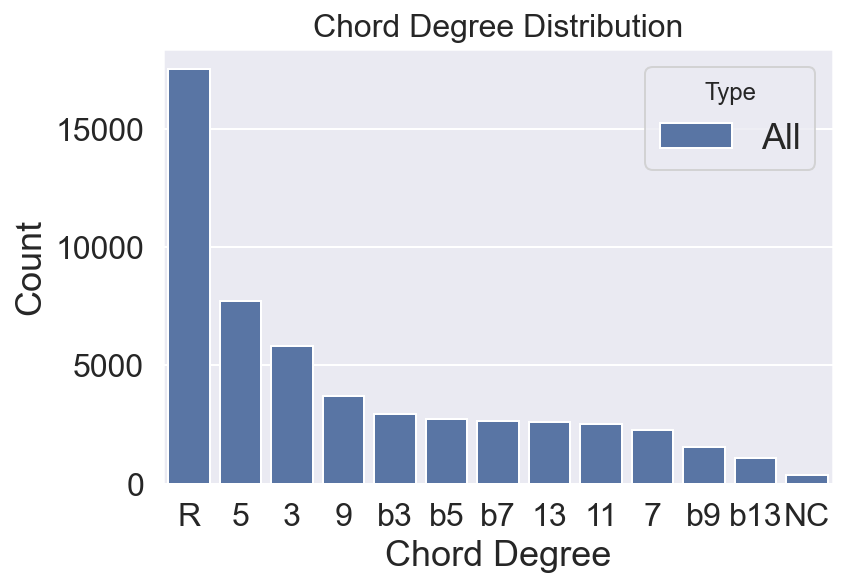

In [51]:
# group by note_degree and count
# degree_counts = df.groupby('note_degree')['note_degree'].count().sort_values(ascending=False)
degree_counts = (
    df[["note_degree", "note"]].groupby(["note_degree"]).count().reset_index()
)
degree_counts = degree_counts.rename(columns={"note": "count"})
degree_counts = degree_counts.sort_values(by="count", ascending=False)

downbeat_note_degrees = (
    df.where(df["note_global_offset"] == df["chord_global_offset"])[
        ["note_degree", "note"]
    ]
    .groupby("note_degree")
    .count()
    .reset_index()
)
downbeat_note_degrees = downbeat_note_degrees.rename(columns={"note": "count"})
downbeat_note_degrees = downbeat_note_degrees.sort_values(by="count", ascending=False)

degree_counts["Type"] = "All"
downbeat_note_degrees["Type"] = "Chord Change Events Only"
res = pd.concat([degree_counts, downbeat_note_degrees])

ax = sns.barplot(data=degree_counts, x="note_degree", y="count", hue="Type")

# set x-axis label
ax.set_xlabel("Chord Degree")
# set y-axis label
ax.set_ylabel("Count")
# set title
ax.set_title("Chord Degree Distribution")
plt.savefig("note_degree_distribution.png")
plt.show()

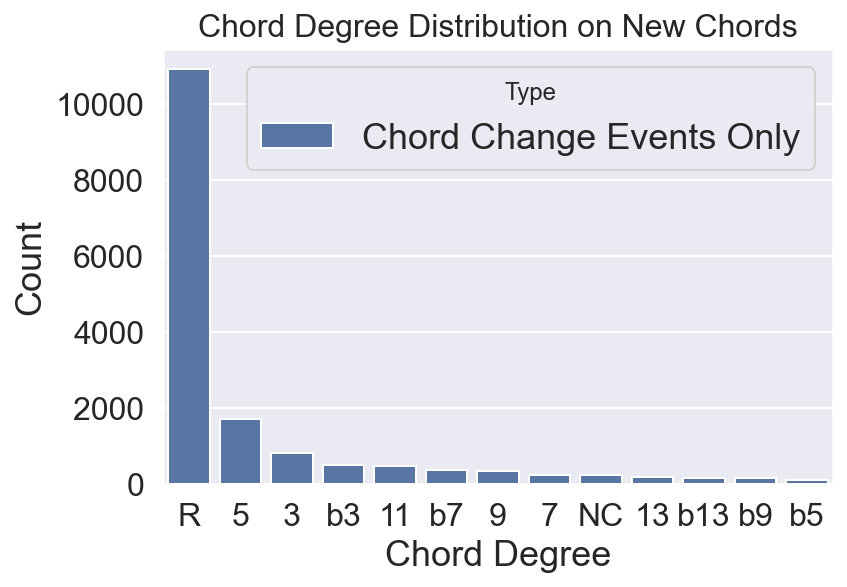

In [52]:
ax = sns.barplot(data=downbeat_note_degrees, x="note_degree", y="count", hue="Type")

# set x-axis label
ax.set_xlabel("Chord Degree")
# set y-axis label
ax.set_ylabel("Count")
# set title
ax.set_title("Chord Degree Distribution on New Chords")
# plt.savefig('note_degree_distribution_downbeats.png')
plt.show()

In [53]:
# bars containing 4 quarter notes only
measures_containing_quarter_notes = (
    df.query('note_duration == 1.0 and type == "Note"')
    .groupby(["title", "measure_number"])
    .size()
)

all_measures = df.groupby(["title", "measure_number"]).size().size

measures_with_all_quarter_notes = measures_containing_quarter_notes[
    measures_containing_quarter_notes == 4
].size

print(
    f"{measures_with_all_quarter_notes} / {all_measures} measures contain 4 quarter notes ({measures_with_all_quarter_notes / all_measures * 100:.2f}%)"
)

7848 / 12497 measures contain 4 quarter notes (62.80%)


In [60]:
# most common n-grams of note degrees

# per bar - not as informative
# ngrams = df.query('type == "Note"').groupby(['title', 'measure_number'])['note_degree'].apply(lambda x: ' '.join(x)).reset_index()['note_degree'].value_counts()

# per chord - probably more informative
ngrams = (
    df.query('type == "Note"')
    .groupby(["title", "chord_global_offset"])["note_degree"]
    .apply(lambda x: " ".join(x))
    .reset_index()["note_degree"]
)
print("Top ngrams of chord degrees - all data")
print(ngrams.value_counts())
print()

four_beat_chord_ngrams = (
    df.query('type == "Note" and chord_duration >= 4.0')
    .groupby(["title", "chord_global_offset"])["note_degree"]
    .apply(lambda x: " ".join(x))
    .reset_index()["note_degree"]
)
print("Top ngrams of chord degrees - chords with duration >= 4 beats")
print(four_beat_chord_ngrams.value_counts())

Top ngrams of chord degrees - all data
R 3                   1034
R 5                    736
R b5                   674
R R                    533
R                      460
                      ... 
9 R 3 13                 1
R 9 b3 3 b7 11           1
11 11 11 R 11 7 11       1
b13 9 b9 b5              1
R 9 b3 b3 R 5            1
Name: note_degree, Length: 3474, dtype: int64

Top ngrams of chord degrees - chords with duration >= 4 beats
R 9 b3 3           320
NC                 179
R 3 11 b5          177
R b9 9 3           103
R b7 13 b13         91
                  ... 
7 13 7 5 3 3 7       1
R b7 13 R b13        1
b13 b13 5 9 7        1
R 7 11 5 b5 11       1
9 b3 3 13 11 13      1
Name: note_degree, Length: 3048, dtype: int64


In [63]:
# Alternative method for finding ngrams
substrings = []
for string in map(lambda x: x.split(' '), four_beat_chord_ngrams.to_numpy()):
    for i in range(len(string)):
        for j in range(i+1, len(string)+1):
            substrings.append(' '.join(string[i:j]))

from collections import Counter
substring_counts = Counter(substrings)
sorted_substrings = sorted(substring_counts.items(), key=lambda x: x[1], reverse=True)
print([s for s in sorted_substrings if len(s[0].split(' ')) == 4]) # ignore repeated notes or repeated subsequences in output

[('R 9 b3 3', 361), ('R 3 11 b5', 195), ('11 11 11 11', 144), ('5 5 5 5', 125), ('R b9 9 3', 115), ('R b7 13 b13', 112), ('R 3 13 5', 111), ('R b7 13 5', 97), ('R 3 5 R', 92), ('R R R R', 87), ('R 5 3 R', 80), ('R R 5 R', 77), ('5 7 R 3', 72), ('R b3 5 R', 69), ('R 9 3 5', 68), ('R b7 5 R', 68), ('R 7 b7 13', 66), ('NC NC NC NC', 65), ('R 5 R 5', 63), ('R 5 R R', 58), ('R 5 R b5', 57), ('R b3 9 R', 55), ('R 9 3 R', 54), ('5 13 b7 7', 54), ('R b5 5 R', 52), ('R 9 b3 11', 50), ('R 9 b3 5', 49), ('R 3 13 b13', 48), ('R 3 5 b5', 48), ('R R b7 13', 48), ('5 b13 13 7', 44), ('5 b9 R b5', 43), ('5 11 3 9', 42), ('R 9 b3 R', 41), ('R b9 9 b9', 41), ('R 5 b3 R', 40), ('5 5 R 5', 38), ('R R 7 b7', 38), ('R 5 R b7', 37), ('R 7 13 5', 36), ('5 11 3 R', 36), ('R R 9 b3', 34), ('R 3 13 3', 34), ('R R R 5', 34), ('R 5 5 R', 33), ('R 5 b7 7', 33), ('R 9 b3 9', 33), ('R 5 b5 11', 32), ('R b9 9 b5', 32), ('R 7 R 9', 31), ('R 5 R b9', 31), ('R 5 R 7', 31), ('5 b9 R 5', 30), ('b3 9 R R', 30), ('b3 b3 b3 b

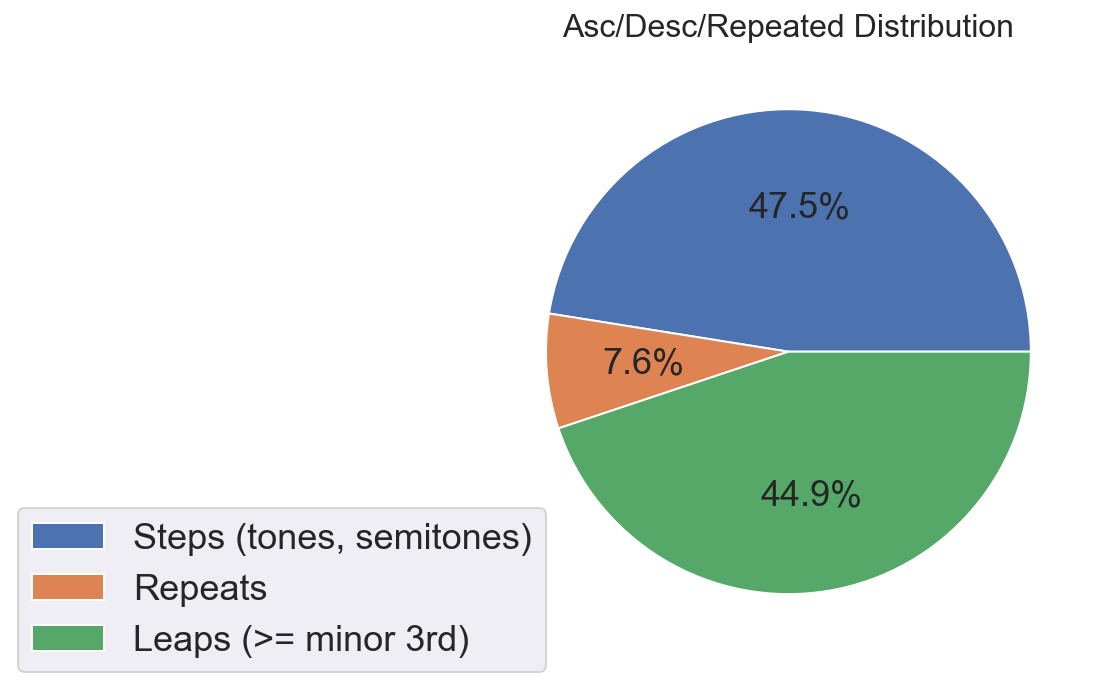

In [70]:
# calculate changes in direction
df.sort_values(by=['title', 'note_global_offset'], inplace=True)
df['prev_dir'] = df.note_direction.shift(periods=-1)
# df['prev_midi'] = df.note_midi.shift(periods=-1)
# df['note_interval'] = df.note_midi - df.prev_midi
# df.query('note_direction != prev_dir and note_direction != 0')


# distribution of note intervals
step_intervals = [-2,-1, 1, 2]
repeat_intervals = [0]
leap_intervals = [-15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

note_intervals = df.groupby('note_interval').count().reset_index()
note_intervals = note_intervals.rename(columns={'note': 'count'})
note_intervals = note_intervals.query('note_interval >= -15 and note_interval <= 15')

step_count = df.query('note_interval in @step_intervals').count().values[0]
repeat_count = df.query('note_interval in @repeat_intervals').count().values[0]
leap_count = df.query('note_interval in @leap_intervals').count().values[0]
asc_leap_count = df.query('note_interval in @leap_intervals and note_interval > 0').count().values[0]
asc_step_count = df.query('note_interval in @step_intervals and note_interval > 0').count().values[0]
desc_leap_count = df.query('note_interval in @leap_intervals and note_interval < 0').count().values[0]
desc_step_count = df.query('note_interval in @step_intervals and note_interval < 0').count().values[0]


int_df = pd.DataFrame([
    ['Steps (tones, semitones)',step_count],
    ['Repeats',repeat_count],
    ['Leaps (>= minor 3rd)',leap_count]
], columns=['IntervalType', 'Count'])

asc_int_df = pd.DataFrame([
    ['Steps (tones, semitones)',asc_step_count],
    ['Repeats',repeat_count],
    ['Leaps (>= minor 3rd)',asc_leap_count]
], columns=['IntervalType', 'Count'])

desc_int_df = pd.DataFrame([
    ['Steps (tones, semitones)',desc_step_count],
    ['Repeats',repeat_count],
    ['Leaps (>= minor 3rd)',desc_leap_count]
], columns=['IntervalType', 'Count'])

total = int_df['IntervalType'].value_counts().values.sum()
asc_total = asc_int_df['IntervalType'].value_counts().values.sum()
desc_total = desc_int_df['IntervalType'].value_counts().values.sum()

def fmt(x):
    return 'n{:.0f}'.format(x, total*x/100)

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(1, 1, figsize=(11, 5))

patches, text, _ = ax.pie(int_df['Count'].values, autopct=lambda x: '{:.1f}%'.format(x, total*x/100))
ax.set_title('Asc/Desc/Repeated Distribution')

fig.tight_layout()

fig.legend(patches, ["Steps (tones, semitones)", "Repeats", "Leaps (>= minor 3rd)"], loc="lower left", ncol=1)

plt.savefig('interval_distribution_pie.png')
plt.show()

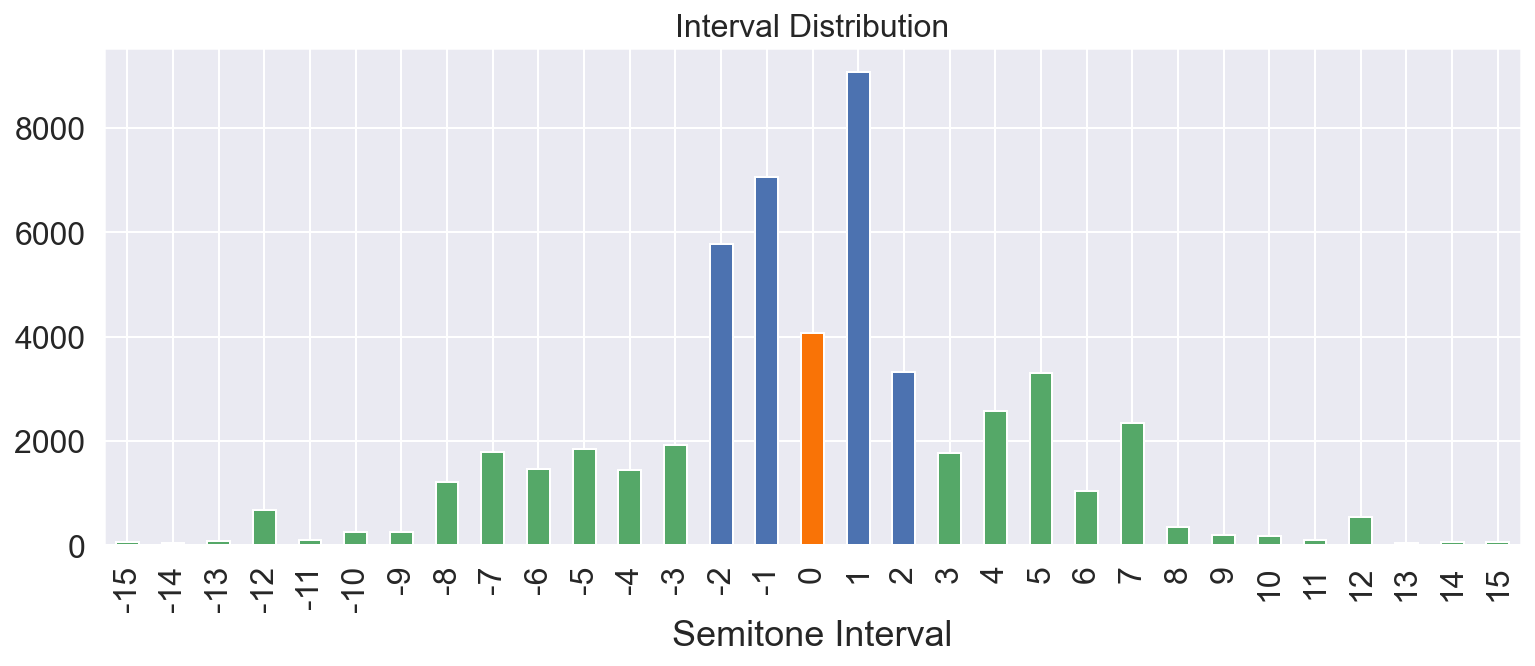

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
note_intervals.plot.bar(x='note_interval', y='count', color=list("gggggggggggggbb")+["#f97306"]+list("bbggggggggggg"), ax=ax)
ax.set_title('Interval Distribution')
ax.set_xlabel('Semitone Interval')
ax.get_legend().remove()

fig.tight_layout()

plt.savefig('interval_distribution.png')
plt.show()

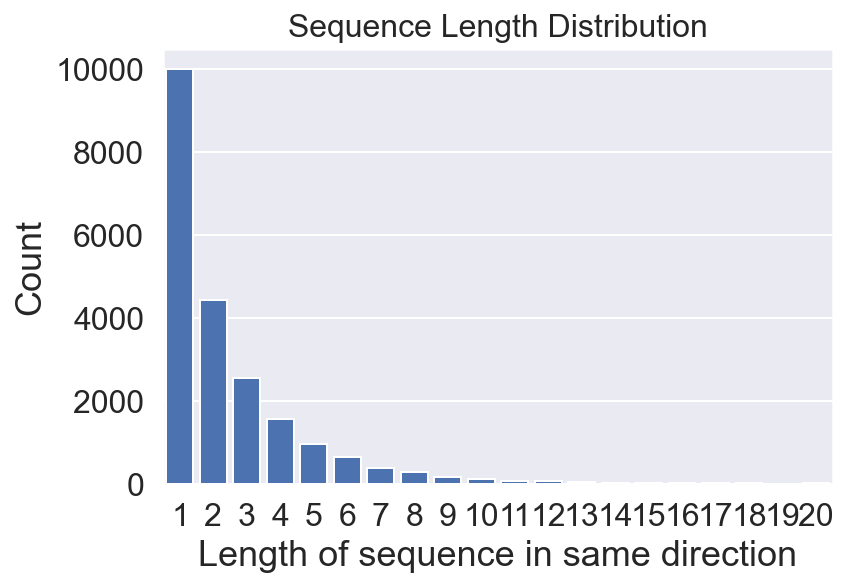

2.449016939608653


<Figure size 432x288 with 0 Axes>

In [74]:
df_notes_only = df.query('type == "Note"')
df_notes_only = df_notes_only.reset_index(drop=True)
line_groups = [g for _, g in df_notes_only.groupby((df_notes_only.note_direction.diff().abs() > 1).cumsum())]

# lengths of a sequence of notes before a change in direction
# seems to exhibit a power law distribution
a,b  = np.array([[g[0].iloc[0], len(g)] for _, g in pd.DataFrame([len(g) for g in line_groups]).groupby(0)][:20]).T
ax = sns.barplot(x=a, y=b, facecolor='b', palette='Blues_d')
# set x-axis label
ax.set_xlabel("Length of sequence in same direction")
# set y-axis label
ax.set_ylabel("Count")
# set title
ax.set_title('Sequence Length Distribution')
plt.show()
plt.savefig('sequence_length.png')

# mean direction calculation
out = []
for x, y in zip(a, b):
    out.extend([x] * y)
print(np.array(out).mean())